### Adapt code to 2D movement (rotation) + starting from random position above

- random starting angle
- random starting x position (not necessarily above landing area)
- x movement!

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive  # what is ipywidgets - slider
from matplotlib import rcParams  # what is rcParams
from numpy.linalg import norm
from numpy.random import randint
import json      #ADDED FOR SAVING FILES
from mpl_toolkits import mplot3d #added for 3D plotting
from scipy.optimize import minimize   # for minimising landing speed
from ipywidgets import interactive 
from matplotlib import rcParams  

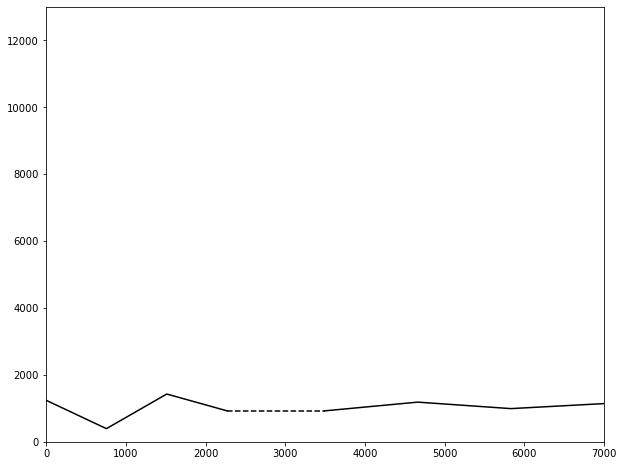

In [3]:
rcParams['figure.figsize'] = (10, 8)

def mars_surface():
    surfaceN = randint(5, 15)
    land = np.zeros((surfaceN, 2), dtype=int)
    
    # first ensure there's a flat landing site at least 1000m long
    landing_site = randint(1, surfaceN-1)
    land[landing_site, 0] = randint(2000, 5000)
    land[landing_site+1, 0] = min(land[landing_site, 0] + randint(1000, 2000), 6999)
    land[landing_site+1, 1] = land[landing_site, 1] = randint(1, 1500)
    
    # fill in the rest of the terrain
    for i in range(landing_site):
        land[i, 0] = (land[landing_site, 0] / landing_site) * i
        land[i, 1] = randint(0, 1500)
    
    for i in range(landing_site + 2, surfaceN):
        land[i, 0] = (land[landing_site + 1, 0] + 
                      (7000 - land[landing_site + 1, 0]) / len(land[landing_site + 2:]) * 
                      (i - (landing_site + 1)))
        land[i, 1] = randint(0, 1500)
    
    # impose boundary conditions
    land[0, 0] = 0
    land[-1, 0] = 6999

    return land, landing_site

def plot_surface(land, landing_site):
    fig, ax = plt.subplots()
    ax.plot(land[:landing_site+1, 0], land[:landing_site+1, 1], 'k-')
    ax.plot(land[landing_site+1:, 0], land[landing_site+1:, 1], 'k-')
    ax.plot([land[landing_site, 0], land[landing_site+1, 0]], 
             [land[landing_site, 1], land[landing_site+1, 1]], 'k--')
    ax.set_xlim(0, 7000)
    ax.set_ylim(0, 13000)
    return ax

def plot_lander(land, landing_site, X, thrust=None, animate=False, step=10):
    if animate:
        def plot_frame(n=len(X)-1):
            ax = plot_surface(land, landing_site)
            ax.plot(X[:n, 0], X[:n, 1], 'b--')
            ax.plot(X[n, 0], X[n, 1], 'b^', ms=20)
            if thrust is not None:
                ax.plot([X[n, 0], X[n, 0] - 100*thrust[n, 0]],
                        [X[n, 1] - 100., X[n, 1] - 100. - 100*thrust[n, 1]], 
                       'r-', lw=10)
        return interactive(plot_frame, n=(0, len(X), step)) #slider
    else:
        ax = plot_surface(land, landing_site) 
        ax.plot(X[:, 0], X[:, 1], 'b--')
        ax.plot(X[-1, 0], X[-1, 1], 'b^')
        return ax

def interpolate_surface(land, x):
    i,  = np.argwhere(land[:, 0] < x)[-1] # segment containing x is [i, i+1]
    m = (land[i+1, 1] - land[i, 1])/(land[i+1, 0] - land[i, 0]) # gradient
    x1, y1 = land[i, :] # point on line with eqn. y - y1 = m(x - x1) 
    return m*(x - x1) + y1

np.random.seed(20) # seed random number generator for reproducible results
land, landing_site = mars_surface()
plot_surface(land, landing_site);

###

def height(land, X):
    return X[1] - interpolate_surface(land, X[0]) #1 in X[1] points to the vertical position y of the lander

assert abs(height(land, [1, land[0, 1]])) < 100.0 # height when on surface left edge should be close to zero
assert abs(height(land, [6999, land[-1, 1]])) < 100.0 # height when on surface at right edge should be close to zero

_land, _landing_site = mars_surface()

## ELIMINATE either above or below

def _height(_land, X):
    return X[1] - interpolate_surface(_land, X[0])

points = np.zeros((10, 2))
points[:, 0] = randint(0, 7000, size=10)
points[:, 1] = randint(0, 13000, size=10)
for i in range(10):
    assert abs(height(_land, points[i, :]) - _height(_land, points[i, :])) < 1e-6


In [4]:

g = 3.711 # m/s^2, gravity on Mars
#m = 3000  #kg , Mass of Lander + Rover + fuel
TSFC = 0.0003 # kg/N*s
# note: fuel in kg

def simulate(X0, V0, land, landing_site, 
             fuel=400, dt=1, Nstep=1000, 
             autopilot=None, print_interval=100, parameters=None):
    
    n = len(X0)       # number of degrees of freedom (2 here)
    X = X0.copy()     # current position
    V = V0.copy()     # current velocity
    Xs = np.zeros((Nstep, n)) # position history (trajectory) 
    Vs = np.zeros((Nstep, n)) # velocity history
    thrust = np.zeros((Nstep, n)) # thrust history
    success = False
    fuel_warning_printed = False
    rotate = randint(-90, 90)                            # degrees, initial angle # was 0 !
    power = 0            # m/s^2, initial thrust power    
    
    for i in range(Nstep):
        Xs[i, :] = X     # Store positions
        Vs[i, :] = V     # Store velocities
        
        if autopilot is not None:
            # call user-supplied function to set `rotate` and `power`
            rotate, power = autopilot(i, X, V, fuel, rotate, power, parameters)
            assert abs(rotate) <= 90
            assert 0 <= power <= 20000
        
            rotate_rad = rotate * np.pi / 180.0 # degrees to radians
            thrust[i, :] = power * np.array([np.sin(rotate_rad), 
                                             np.cos(rotate_rad)])
            if fuel <= 0: 
                if not fuel_warning_printed:
                    print("Fuel empty! Setting thrust to zero")
                    fuel_warning_printed = True
                thrust[i, :] = 0
            else:
                fuel -= TSFC * power * dt  
        
        m = 2600 + fuel  #kg , Mass of Lander + Rover + fuel  # fuel Mass loss
        
        A = np.array([0, -g]) + thrust[i, :]/m # acceleration
        V += A * dt                          # update velocities
        X += V * dt                          # update positions
        
        if i % print_interval == 0: 
            print(f"i={i:03d} X=[{X[0]:8.3f} {X[1]:8.3f}] V=[{V[0]:8.3f} {V[1]:8.3f}]"
                  f" thrust=[{thrust[i, 0]:8.3f} {thrust[i, 1]:8.3f}] fuel={fuel:8.3f} rotate={rotate:8.3f}") 
        
        # check for safe or crash landing
        if X[1] < interpolate_surface(land, X[0]):
            if not (land[landing_site, 0] <= X[0] and X[0] <= land[landing_site + 1, 0]):
                print("crash! did not land on flat ground!")
            elif rotate != 0:
                print("crash! did not land in a vertical position (tilt angle = 0 degrees)")
            elif abs(V[1]) >= 40:
                print("crash! vertical speed must be limited (<40m/s in absolute value), got ", abs(V[1]))
            elif abs(V[0]) >= 20:
                print("crash! horizontal speed must be limited (<20m/s in absolute value), got ", abs(V[0]))
            else:
                print("safe landing - well done!")
                success = True
            Nstep = i
            break
    
    return Xs[:Nstep,:], Vs[:Nstep,:], thrust[:Nstep,:], success, fuel, rotate


### Trigonometry to reach horizontal target

Create new var?  Xtarget = (land[landing_site+1, 0] + land[landing_site, 0]) // 2 

Target rotation angle? + trust in that direction

Tangent(angle) = opposite / adjacent
tan(rotate) = dist / height

In [5]:
def proportional_autopilot(i, X, V, fuel, rotate, power,parameters):
    K_h,K_p,K_new = parameters
    c_v = 10.0 # target landing speed, m/s #c vertical
    c_h = 5.0 #c horizontal and vertical #trade-off for rotation to go back to 0
    
    h = height(land, X)
    
    # Horizontal displacement
    
    Xtarget = (land[landing_site+1, 0] + land[landing_site, 0]) // 2 
    dist = Xtarget-X[0]  #X[i,0], pass the histry of X (same for V)
    
    rotate = np.rad2deg(np.arctan2(dist,h))      
        
    # Combine vertical & horizontal errors
    v_target_vert = -(c_v + K_h*h);
    v_target_horz = abs(c_h+K_new*dist);
    v_err_vert = abs(v_target_vert - V[1])
    v_err_horz = abs(v_target_horz - V[0])
    e =  v_err_vert + v_err_horz;  # before: e = - (c + K_h*h + V[1])  # abs(dist) here ??
    
    Pout = K_p*e                     
    power = min(max(Pout, 0.0), 20000.0)
    
    
    if i % 100 == 0:
        print(f'e={e:8.3f} Pout={Pout:8.3f} power={power:8.3f}')     
    return (rotate, power)

### TESTS

In [12]:
#np.random.seed(123) # seed random number generator for reproducible results
land, landing_site = mars_surface()

K_h_list = [0.0005] 
K_p_list = [500] #works best with 50 ?
K_new_list = [0.0005] #to be renamed

count = 0
land_speed_results = np.zeros((len(K_h_list),len(K_p_list)))
fuel_results = np.zeros((len(K_h_list),len(K_p_list)))

for i, K_h in enumerate(K_h_list):
    for j, K_p in enumerate(K_p_list):
        for k, K_new in enumerate(K_new_list):
            X0 = [randint(1000, 5000), randint(10000, 13000)]   # HERE - x not above landing surface (betwen bond conditions) & y - replace with value found
            # before: X0 = [(land[landing_site+1, 0] + land[landing_site, 0]) // 2, randint(1500, 3000)]  !changed intitial range
            V0 = [0., 0.]   # CHANGE with values found

            Xs, Vs, thrust, success, fuel, rotate = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=2000, 
                                            autopilot=proportional_autopilot, fuel=400,parameters=[K_h,K_p,K_new])
            land_speed_results[i, j] = Vs[-1,1]
            fuel_results[i, j] = fuel
            count += success

#print(land_speed_results)

#Xtarget = (land[landing_site+1, 0] + land[landing_site, 0]) // 2 
#print(Xtarget)

plot_lander(land, landing_site, Xs, thrust, animate=True, step=10)

e=  20.186 Pout=10092.757 power=10092.757
i=000 X=[3149.003 10290.996] V=[   0.034   -0.036] thrust=[1025.390 10040.534] fuel= 399.697 rotate=   5.831
e=   4.266 Pout=2133.234 power=2133.234
i=100 X=[3163.544 10242.523] V=[   2.412  -13.786] thrust=[ 214.473 2122.425] fuel= 378.641 rotate=   5.770
e=  17.313 Pout=8656.496 power=8656.496
i=200 X=[3195.804 9998.075] V=[   4.423  -30.898] thrust=[ 862.105 8613.460] fuel= 360.736 rotate=   5.716
e=  22.310 Pout=11155.182 power=11155.182
i=300 X=[3256.063 9663.255] V=[   7.734  -34.446] thrust=[1075.082 11103.255] fuel= 330.933 rotate=   5.530
e=  23.668 Pout=11833.792 power=11833.792
i=400 X=[3352.147 9329.574] V=[  11.437  -31.868] thrust=[1050.685 11787.056] fuel= 296.096 rotate=   5.094
e=  23.485 Pout=11742.345 power=11742.345
i=500 X=[3484.113 9029.954] V=[  14.838  -28.061] thrust=[ 894.173 11708.250] fuel= 260.644 rotate=   4.367
e=  22.870 Pout=11434.941 power=11434.941
i=600 X=[3647.056 8767.909] V=[  17.595  -24.474] thrust=[ 667

interactive(children=(IntSlider(value=1875, description='n', max=1876, step=10), Output()), _dom_classes=('wid…

In [46]:

x = np.rad2deg(np.pi/2)
print(x)

90.0


In [ ]:
## OLD CODE FOR ROTATE IN AUTOPILOT

    #if dist != 0:
    #if dist > 0:
        #rotate = np.rad2deg(np.arctan(dist/h))
    #elif dist < 0:
        #rotate = -np.rad2deg(np.arctan(dist/h))
        # arctan is in radians # converted to degrees